# DS 310 Fall 2020 
# Lab 5 : Clustering

Clustering algorithms try to learn, from the data, an optimal division (clusters) or discrete labeling of groups of points.

Many clustering algorithms are available in Scikit-Learn and perhaps the simplest to understand is an algorithm known as *k-means clustering*, which is implemented in ``sklearn.cluster.KMeans``.

In [1]:
#The usual libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

## Part 1 : An introduction to k-Means clustering algorithm

The goal of the *k*-means algorithm is to search for a pre-determined number of clusters (which you will define!) in an unlabeled (multidimensional) dataset.

The basic idea consists of two things, the **cluster center** and the **remaining points**:

- The "cluster center" is the arithmetic mean of all the points belonging to the cluster.
- Each "point" is closer to its own cluster center than to other cluster centers.

Those two assumptions are the basis of the *k*-means model.
We look at a simple dataset and see the *k*-means result.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


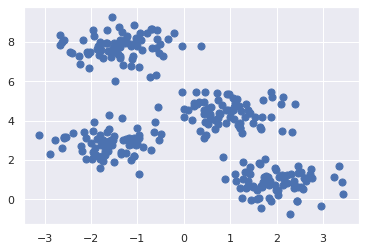

In [2]:
#First, let's generate a two-dimensional dataset containing four distinct blobs.
#To emphasize that this is an unsupervised algorithm, we will leave the labels out of the visualization

from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

In [3]:
#It's easy to identify the clusters by loooking at them. But, how does the algorithm do it? We will see this in the next few sections.
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

Next we see the clusters and the cluster centers : 
1. Visualizing the clusters :
2. We also plot the cluster centers as determined by the *k*-means estimator:

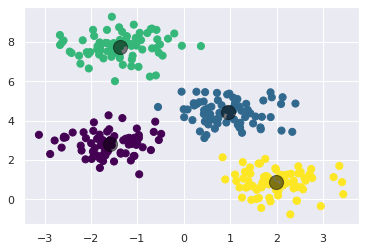

In [4]:
#1
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

#2
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

How does the K-Means clustering algorithm finds the clusters? 

Answer : The typical approach to *k*-means involves an intuitive iterative approach known as Cluster Assignment & Centroid Computation.

## Part 2 : k-Means Algorithm: Cluster Assignment & Centroid Computation

The basic idea is this: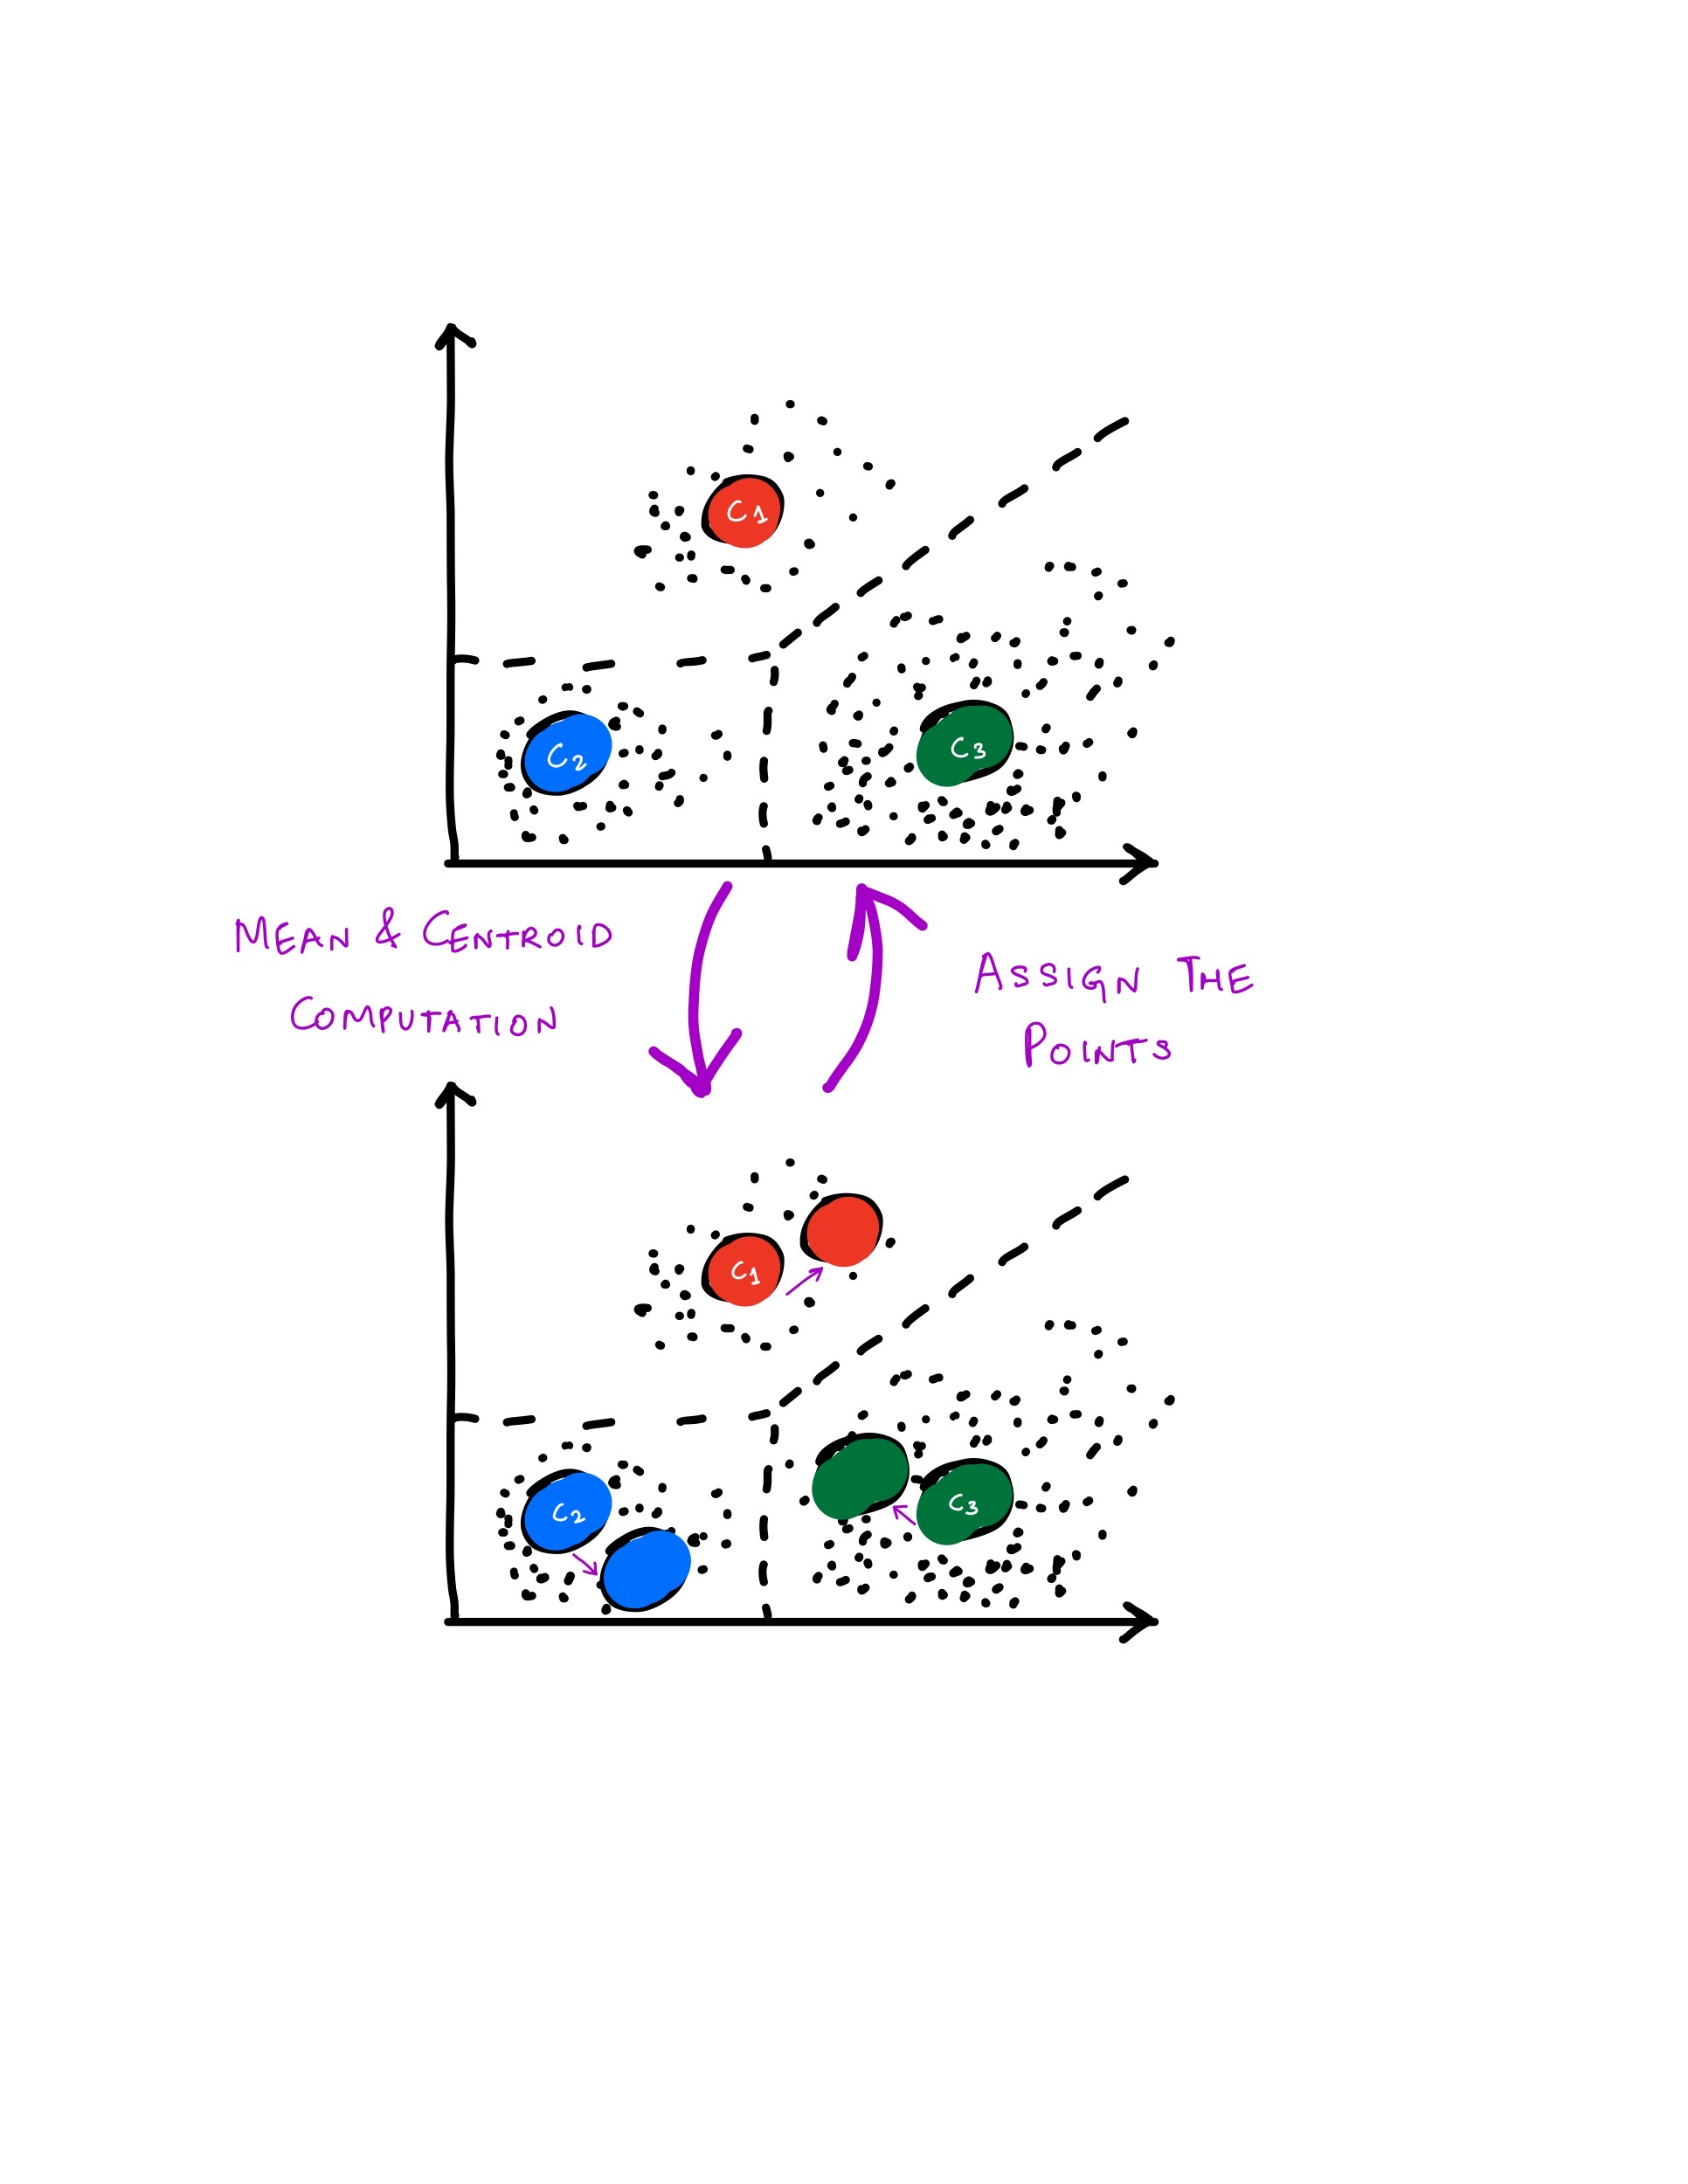


Basically, we do the following steps:

1. Start with some random cluster centers
2. Repeat until converged
   1. *Cluster Assignment*: assign points to the nearest cluster center
   2. *Centroid Computation*: set the cluster centers to the mean 


Generally, each repetition of the cluster assignment and centroid computation will always result in a better estimate of the cluster characteristics.

Visualizing :

The *k*-Means algorithm implementation:

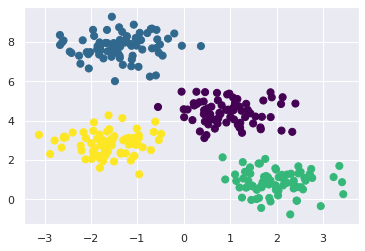

In [5]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

### There may be a few issues that may come up when using the above method.



## Issue 1. The globally optimal result may not be achieved
First, although the cluster assignment and centroid computation procedure is guaranteed to improve the result in each step, there is no assurance that it will lead to the *global* best solution.
For example, if we use a different random seed in our simple procedure, the particular starting guesses lead to poor results:

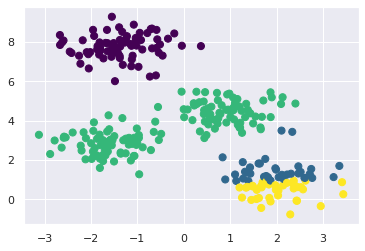

In [6]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Here the approach has converged, but has not converged to a globally optimal configuration. For this reason, it is common for the algorithm to be run for multiple starting guesses, as indeed Scikit-Learn does by default (set by the ``n_init`` parameter, which defaults to 10).

## Issue 2: You MUST select the number of clusters beforehand
You must tell how many clusters you expect: it cannot learn the number of clusters from the data.

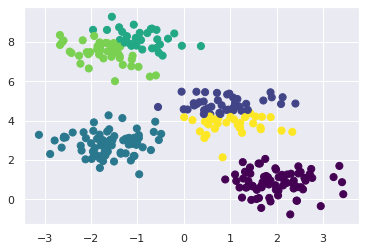

In [7]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

#Two approaches (BEYOND THE SCOPE OF THIS LAB) exist called :

1. Silhouette Analysis : (see http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)

2. Gaussian Mixture Models (MORE COMPLEX! see https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#examples-using-sklearn-mixture-gaussianmixture)

## Issue 3: k-means is limited to linear cluster boundaries

The boundaries between *k*-means clusters will always be linear, which means that it will fail for more complicated boundaries.
Consider the following data, along with the cluster labels found by the typical *k*-means approach:

In [8]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

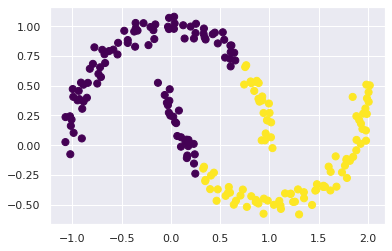

In [9]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

# This situation is reminiscent of the discussion in Lab 4 : SVM, where we used a kernel transformation to project the data into a higher dimension where a linear separation is possible.
We might imagine using the same trick to allow *k*-means to discover non-linear boundaries.

/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


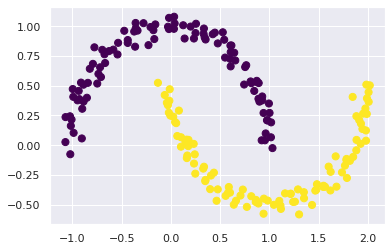

In [10]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

#We call this graph below as the half moons because the data belongs to either the blackcurrant or yellow classes.

We see that with this kernel transform approach, the kernelized *k*-means is able to find the more complicated nonlinear boundaries between clusters.

## Issue 4 : k-means may be slow for large numbers of samples
Since each iteration of *k*-means must access every point in the dataset, the algorithm can be relatively slow as the number of samples grows.

# Example: k-means on digits

To start, let's take a look at applying *k*-means on the same simple digits data. Here we will attempt to use *k*-means to try to identify similar digits *without using the original label information*; this might be similar to a first step in extracting meaning from a new dataset about which you don't have any *a priori* label information.

We will start by loading the digits and then finding the ``KMeans`` clusters.
The digits consist of 1,797 samples with 64 features, where each of the 64 features is the brightness of one pixel in an 8×8 image:

In [11]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

The clustering can be performed as we did before:

In [12]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

The result is 10 clusters in 64 dimensions.
Notice that the cluster centers themselves are 64-dimensional points, and can themselves be interpreted as the "typical" digit within the cluster.
Let's see what these cluster centers look like:

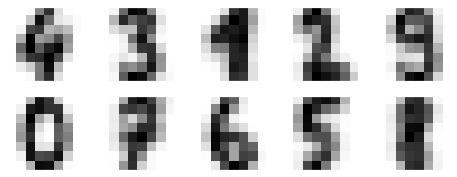

In [13]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

We see that *even without the labels*, ``KMeans`` is able to find clusters whose centers are recognizable digits, with perhaps the exception of 8.

Because *k*-means knows nothing about the identity of the cluster, the 0–9 labels may be permuted.
We can fix this by matching each learned cluster label with the true labels found in them:

In [14]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

Now we can check how accurate our unsupervised clustering was in finding similar digits within the data:

In [15]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7952142459654981

With just a simple *k*-means algorithm, we discovered the correct grouping for 80% of the input digits!
Let's check the confusion matrix for this:

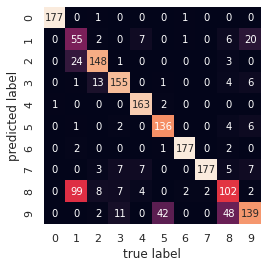

In [16]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

#Part 2 : Hierarchical clustering

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import numpy as np


In [18]:
customer_data = pd.read_csv('https://raw.githubusercontent.com/suhasbn/DS310/master/shopping-data.csv')
customer_data.shape

(200, 5)

In [19]:
customer_data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


Our dataset has five columns: CustomerID, Genre, Age, Annual Income, and Spending Score. To view the results in 2D feature space, we retain only two of these five columns. We can remove CustomerID column, Genre, and Age. We will retain the Annual Income (in thousands of dollars) and Spending Score (1-100) columns. The Spending Score column signifies how often a person spends money in a mall on a scale of 1 to 100 with 100 being the highest spender. 

In [20]:
data = customer_data.iloc[:, 3:5].values
data.shape

(200, 2)

Next, we need to know the clusters that we want our data to be split to. We will use the scipy library to create the dendrograms for our dataset.

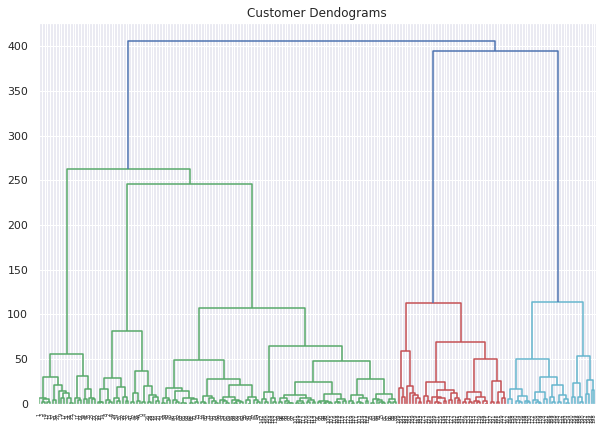

In [21]:
import scipy.cluster.hierarchy as shc #We import the hierarchy class of the scipy.cluster library as shc.
#The hierarchy class has a dendrogram method which takes the value returned by the linkage method of the same class. 
#The linkage method takes the dataset and the method to minimize distances as parameters. 
plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(data, method='ward')) #We use 'ward' as the method since it minimizes then variants of distances between the clusters.

If we draw a horizontal line (around the 125-200 mark) that passes through longest distance without a horizontal line, we get 5 clusters.

Now we know the number of clusters for our dataset, the next step is to group the data points into these five clusters. To do so we will use the AgglomerativeClustering class of the sklearn.cluster library.

In [22]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
cluster.fit_predict(data)

array([4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3,
       4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 1,
       4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 0, 2, 0, 2,
       1, 2, 0, 2, 0, 2, 0, 2, 0, 2, 1, 2, 0, 2, 1, 2, 0, 2, 0, 2, 0, 2,
       0, 2, 0, 2, 0, 2, 1, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2,
       0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2,
       0, 2])

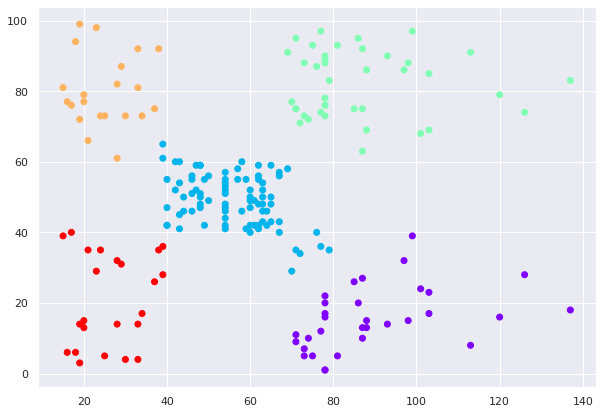

In [23]:
#You can see the cluster labels from all of your data points. 
#Since we had five clusters, we have five labels in the output i.e. 0 to 4.
#As a final step, let's plot the clusters to see how actually our data has been clustered:
plt.figure(figsize=(10, 7))
plt.scatter(data[:,0], data[:,1], c=cluster.labels_, cmap='rainbow')

# Lab 5 Exercise (Due Nov 20th, 2020 11:59 PM EST)
##Q1. 

a) What are your conclusions from the above graph with regards to earning v/s spending for the five clusters? 

b) Does the clustering make sense in a real world scenario?


##Q2. 

a) Implement a density based clustering method (such as DBSCAN : https://scikit-learn.org/0.15/modules/generated/sklearn.cluster.DBSCAN.html) for a dataset which is based on the "half moons" example we discussed today in class.

###Import the data :
from sklearn.datasets import make_moons

moons_X, moon_y = make_moons(n_samples = 2000)

###Here : moons_X is our data, moon_y is our Labels




b) Compare the results to the k-Means Clustering algorithm.

c) Is there a difference in the results?

d) Explain why if there is a difference or why not if there isn't any.

In [24]:
from sklearn.datasets import make_moons

moons_X, moon_y = make_moons(n_samples = 2000)

In [25]:
moons_X.shape

(2000, 2)

In [26]:
moon_y.shape

(2000,)

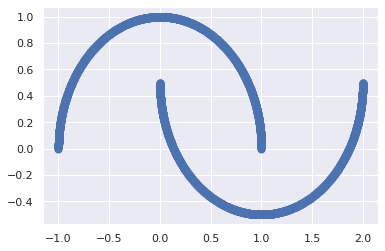

In [27]:
plt.scatter(moons_X[:, 0], moons_X[:, 1], s=50);

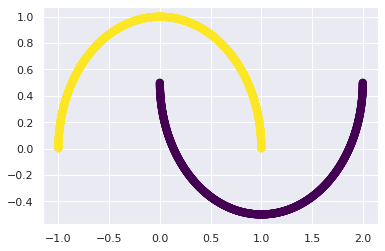

In [32]:
from sklearn.cluster import DBSCAN
labels = DBSCAN().fit_predict(moons_X)
plt.scatter(moons_X[:, 0], moons_X[:, 1], c=labels,
            s=50, cmap='viridis');

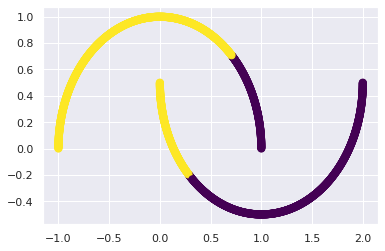

In [29]:
from sklearn.cluster import KMeans
labels = KMeans(2, random_state=0).fit_predict(moons_X)
plt.scatter(moons_X[:, 0], moons_X[:, 1], c=labels,
            s=50, cmap='viridis');